## Results comparisons

In this notebook, we will load all the trained models and compare their performances on the test dataset

In [1]:
# This is for Kaggle notebook.
# import module we'll need to import our custom module
from shutil import copytree

# copy our file into the working directory (make sure it has .py suffix)
copytree(src = "../input/myfedprox/MyFedProx/", dst = "../working/MyFedProx")
copytree(src = "../input/mlbiomodels/models", dst = "../working/models")

'../working/models'

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from torchvision.models import mobilenet_v2
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from MyFedProx.dataset_splits import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# load the different models that have been trained and compare them
def build_model():
    model = mobilenet_v2().to(device)
    model.classifier[1] = torch.nn.Linear(1280, 2).to(device)
    model.eval()
    return model

classical_model = build_model()
unfair_size_model = build_model()
unfair_repartition_model = build_model()
fair_split_model = build_model()

classical_model.load_state_dict(torch.load("models/model_classical_training.pt", map_location=torch.device(device)))
fair_split_model.load_state_dict(torch.load("models/model_fair_split.pt", map_location=torch.device(device)))
unfair_size_model.load_state_dict(torch.load("models/model_unfair_size_split.pt", map_location=torch.device(device)))
unfair_repartition_model.load_state_dict(torch.load("models/model_unfair_repartition_split.pt", map_location=torch.device(device)))

models = {"classical_model" : classical_model, 
          "fair_split_model" : fair_split_model,
          "unfair_size_model" : unfair_size_model,
          "unfair_repartition_model" : unfair_repartition_model}

In [6]:
# load the test dataset
_, test_loader = get_SIIM_ISIC("/kaggle/input/siim-isic-melanoma-classification/jpeg/train/", "/kaggle/input/siim-isic-melanoma-classification/train.csv",type="normal", train_size=0.8, test_size=0.2, batch_size=32, device=device, total_size=None, resnet50=True, balanced=True)

<torch.utils.data.dataset.Subset object at 0x7816a1c37fa0> <torch.utils.data.dataset.Subset object at 0x7816a1c369b0>


In [7]:
# evaluate the models and store the results in a dataframe
results = pd.DataFrame(columns=["model", "accuracy", "precision", "recall", "f1-score", "confusion_matrix"])
for model_name, model in models.items():
    y_true = []
    y_pred = []
    for inputs, labels in iter(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.max(1,keepdim=True).indices.tolist()
        y_pred += predicted.tolist()
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    results = pd.concat([results, pd.DataFrame([{"model": model_name, "accuracy": accuracy, "precision": precision, "recall": recall, "f1-score": f1_score, "confusion_matrix": confusion_matrix}])])

In [8]:
results

,model,accuracy,precision,recall,f1-score,confusion_matrix
0,classical_model,0.763948,0.785714,0.739496,0.761905,"[[90, 24], [31, 88]]"
0,fair_split_model,0.785408,0.794872,0.781513,0.788136,"[[90, 24], [26, 93]]"
0,unfair_size_model,0.785408,0.748201,0.873950,0.806202,"[[79, 35], [15, 104]]"
0,unfair_repartition_model,0.759657,0.688623,0.966387,0.804196,"[[62, 52], [4, 115]]"


If we look at those results we can see that no matter how the data is split among all the clients, the performances stay almost the same.

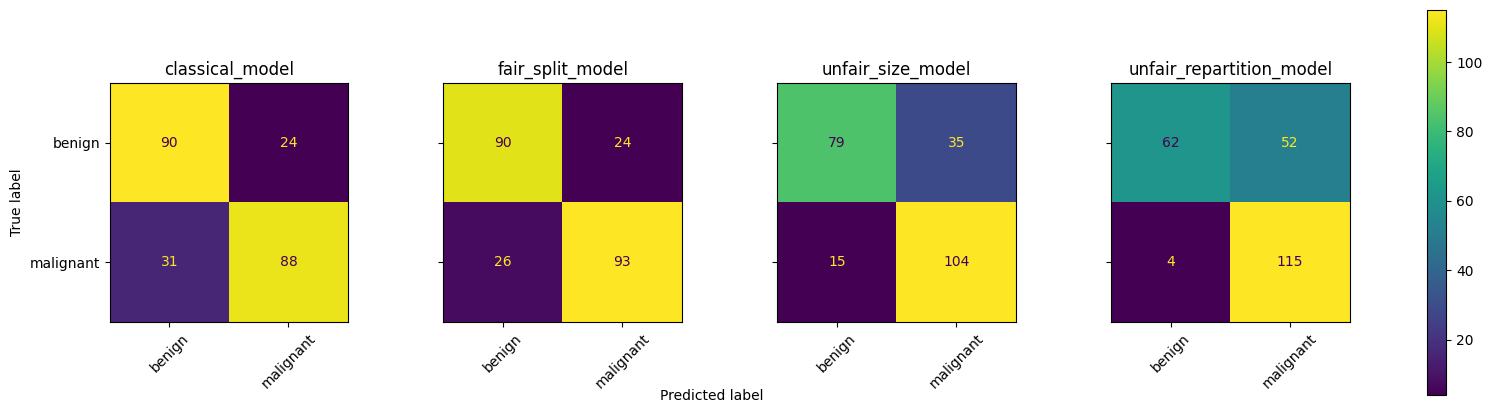

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay


f, axes = plt.subplots(1, len(models), figsize=(20, 5), sharey='row')
for i, row in enumerate(results.iterrows()):
    disp = ConfusionMatrixDisplay(row[1]["confusion_matrix"], display_labels=["benign", "malignant"])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(row[1]["model"])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

    

With the confusion matrix, it's better if we have high values in diagonal. We can see it's the first two models that have the highest values which means the predictions are more accurate. Their predictions are very similar when the dataset is equally split.
The last models have better predictions for cancerous images but have also a lot more false positive

### Conclusion

It looks like the most important is the whole dataset itself that of course will impact a lot the model's performance. If there is enough data, unbiased and balanced. The way we split the dataset among all client seems to have little impact in federated learning